# <font color='blue'>Project 1: Finding Lane Lines on the Road</font>
<div class= "alert alert-block alert-info"> *Use some basic computer vision techniques to find lane markings on the road. *</div>

## Result

### Image

<figure>
 <img src="helper_functions_used.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;">line segments detected using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="draw_line_improved.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;">line segments  connected/averaged/extrapolated</p> 
 </figcaption>
</figure>

### Video

1. [solidYellowLeft Video](https://youtu.be/VCLtHHBUPZA)
1. [solidWhiteRight Video](https://youtu.be/tFdcKgX3r5c)
1. [challenge Video](https://youtu.be/RUNxUG4AucU)

## Project Content

### Set up parameters and helper functions

#### Useful packages for this project

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


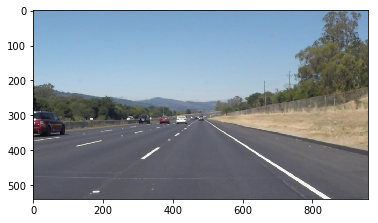

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

#### Helper functions from the lesson

In [3]:
#Some helper functions
import math

def color_selection(img):
    # Define color selection criteria
    red_threshold = 150
    green_threshold = 150
    blue_threshold = 0
    
    color_image = np.copy(img)
    
    rgb_threshold = [red_threshold, green_threshold, blue_threshold]
    
    # Do a boolean or with the "|" character to identify
    # pixels below the thresholds
    thresholds = (img[:,:,0] < rgb_threshold[0])\
                  | (img[:,:,1] < rgb_threshold[1])\
                  | (img[:,:,2] < rgb_threshold[2])
            
    color_image[thresholds] = [0,0,0]
    
    return color_image
    
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
def draw_lines(img, lines, color=[255, 0, 0], thickness=15):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, method = 'original'):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    if method == 'original':
        draw_lines(line_img, lines)
    if method == 'improved':
        slopebased_draw_lines(line_img, lines)
    
    return line_img

# Python 3 has support for cool math symbols.
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

#### Test images to proceed before moving on videos

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

#### Global parameters used for Canny Edge, Region of interest mask, Hough Transform, Slope of left and right line

In [5]:
#Global parameters 
#Gaussian smoothing
kernel_size = 3

# Canny Edges
low_threshold  = 50
high_threshold = 150

# Region of interest mask
imshape = image.shape
left_bottom   = [0,imshape[0]]
right_bottom  = [imshape[1],imshape[0]]
left_apex     = [imshape[1]//2-100, 2*imshape[0]//3] 
right_apex    = [imshape[1]//2+100, 2*imshape[0]//3]

# Hough Transform
rho          = 2         # distance resolution in pixels of the Hough grid
theta        = np.pi/180 # angular resolution in radians of the Hough grid
threshold    = 15        # minimum number of votes (intersections in Hough grid cell)
min_line_len = 40        # minimum number of pixels making up a line
max_line_gap = 20        # maximum gap in pixels between connectable line segments

#Drawn line parameters
global_aver_negative_slope, global_aver_positive_slope = [],[]

## Build a Lane Finding Pipeline

Use parameters above to build the pipeline and run it on all test_images.<br> 
The results are save into the `test_images_output` directory to use in writeup report

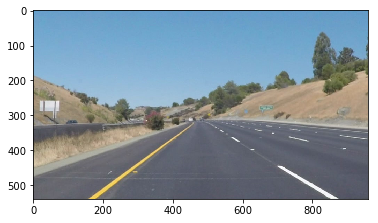

In [6]:
test_image = mpimg.imread('test_images/solidYellowCurve2.jpg')
plt.imshow(test_image)

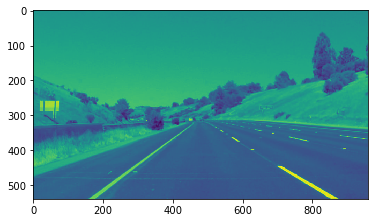

In [7]:
#Convert image to gray_scale
gray_image = grayscale(test_image)
plt.imshow(gray_image)

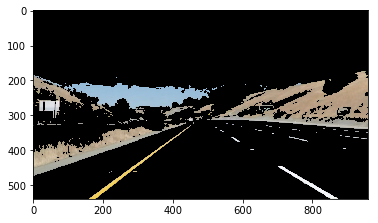

In [8]:
#Color selection
grayscale_image = color_selection(test_image)
plt.imshow(grayscale_image)

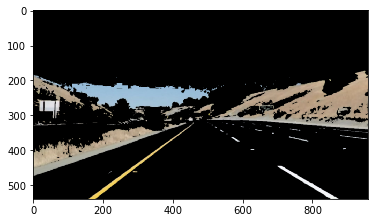

In [9]:
#Applies a Gaussian Noise kernel
blur_gray_image = gaussian_blur(grayscale_image, kernel_size) # Remove noise
plt.imshow(blur_gray_image)

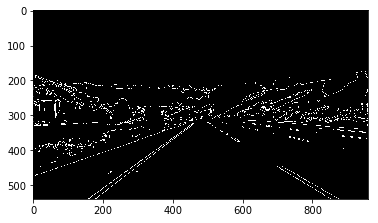

In [10]:
#Applies the Canny transform
edges_image = canny(blur_gray_image, low_threshold, high_threshold)
plt.imshow(edges_image, cmap='Greys_r')

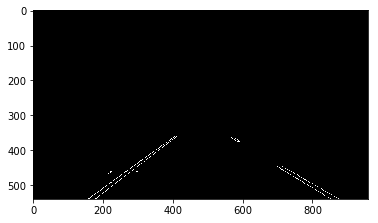

In [11]:
#Applies an image mask
vertices = np.array([[left_bottom, left_apex, right_apex, right_bottom]], dtype=np.int32)
masked_edges_image = region_of_interest(edges_image, vertices)
plt.imshow(masked_edges_image, cmap='Greys_r')

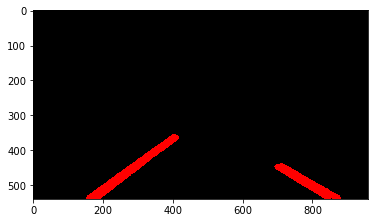

In [12]:
# Returns an image with hough lines drawn
lines = hough_lines(masked_edges_image, rho, theta, threshold, min_line_len, max_line_gap)
plt.imshow(lines, cmap='Greys_r')

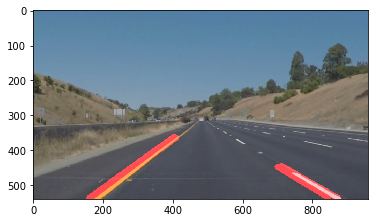

In [13]:
# Returns a combination of hough lines drawn image and original image
result = weighted_img(lines,mpimg.imread('test_images/whiteCarLaneSwitch.jpg'))
mpimg.imsave("helper_functions_used.png", result)
plt.imshow(result)

From the image above, I take average and extrapolate the line segments from the bottom to the top of the region of interest.<br>
Note: In case of video, the slope and position of left and right line were took average in 20 frames.<br> 
- Input: hough lines
- Output : a single, solid line over the left lane line / a single, solid line over the right lane line. 
***
    - `slopebased_draw_lines`: separate line segments based on its slope value into left and right group.
    - `extrapolate`: take average value at each group then extrapolate to top and bottom the region of interest.
    - `average_list`: take average value over frames(20 frames) to make the pipeline more stable 

In [14]:
#Store element to fixed size of one list and return the average value of that list
#deque from collections.deque is an option but access speed/ reliability issues

def average_list(l_length, l, element):
    
    if len(l) > 0:
        l = l[-l_length:]
        average_l = [sum(sub_l,0.0)/len(sub_l) for sub_l in zip(*l)]
        
        if (abs(average_l[0]-element[0][0])/average_l[0]) > 0.2 or \
           (abs(average_l[1]-element[0][1])/average_l[1]) > 0.2 :
                l += [(average_l[0],average_l[1])]
                l = l[-l_length:]
        else:
            l += element  #add element to right side of list
            l = l[-l_length:] #maxlen =  list_length
    else:
        l += element  #add element to right side of list
        l = l[-l_length:] #maxlen =  list_length   
    
    if l ==[]:
        return 0

    return [sum(sub_l,0.0)/len(sub_l) for sub_l in zip(*l)] 

In [15]:
# average the position of each of the lines (x1,x2...) and (y1,y2...) and their slope in ONE FRAME
# extrapolate to the top and bottom of the lane
# use y values of region on interest to calculate their x values
def extrapolate(slope_lines):
    
    #average = [X,Y,SLOPE]
    average = [float(sum(l))/len(l) for l in zip(*slope_lines)]
    
    #x = (y-y0)/slope + x0
    if len(average) > 0:
        top_x = (left_apex[1] - average[1])/average[2] + average[0]
        bottom_x = (left_bottom[1] - average[1])/average[2] + average[0]
    else: 
        top_x = 0
        bottom_x = 0
    
    return [(top_x, bottom_x)]

In [16]:
def slopebased_draw_lines(img, lines, color=[255, 0, 0], thickness=15):
    
    # depends on situations, we have both minus & plus slope or just one.
    positive_slope_lines, negative_slope_lines = [],[]
    aver_negative_slope, aver_positive_slope   = [],[]
    global global_aver_negative_slope, global_aver_positive_slope
    
    if lines is not None: 
        for line in lines:
            for x1,y1,x2,y2 in line:
                if x2 - x1 == 0. : continue
                slope = float(y2-y1)/float(x2-x1)
                
                if abs(slope) < .1  :continue
                if slope > 0:
                    positive_slope_lines += [((x1+x2)*0.5,(y1+y2)*0.5, slope)]
                else:
                    negative_slope_lines += [((x1+x2)*0.5,(y1+y2)*0.5, slope)]
    
    # In ONE FRAME
    aver_negative_slope = extrapolate(negative_slope_lines) 
    aver_positive_slope = extrapolate(positive_slope_lines)    
    
    # In 20 FRAME (take average value in latest 20 frames)
    aver_negative_slope = average_list(20, global_aver_negative_slope, aver_negative_slope )
    aver_positive_slope = average_list(20, global_aver_positive_slope, aver_positive_slope )
    
    # Draw 2 lines
    cv2.line(img, (int(aver_negative_slope[1]), left_bottom[1]) ,\
            (int(aver_negative_slope[0]), left_apex[1]), color, thickness)    
    cv2.line(img, (int(aver_positive_slope[1]), left_bottom[1]) ,\
            (int(aver_positive_slope[0]), left_apex[1]), color, thickness)

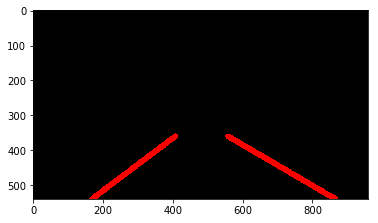

In [17]:
# Returns an image with hough lines drawn
# Note: 'slopebased_draw_lines' is called when method = 'improved' 
improved_lines = hough_lines(masked_edges_image, rho, theta, threshold, min_line_len, max_line_gap, method = 'improved')
plt.imshow(improved_lines, cmap='Greys_r')

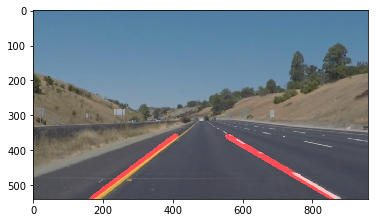

In [18]:
# Returns a combination of hough lines drawn image and original image
result = weighted_img(improved_lines,mpimg.imread('test_images/whiteCarLaneSwitch.jpg'))
mpimg.imsave("draw_line_improved.png", result)
plt.imshow(result)

In [19]:
# This function adapts all steps above
def process_image(image, method = 'improved'):
    #Applies the Grayscale transform
    gray = color_selection(image)
    
    #Applies a Gaussian Noise kernel
    blur_gray = gaussian_blur(gray, kernel_size) # Remove noise
    
    #Applies the Canny transform
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    #Applies an image mask
    vertices = np.array([[left_bottom, left_apex, right_apex, right_bottom]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    
    # Returns an image with hough lines drawn
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap, method = method)
    
    # Returns a combination of hough lines drawn image and original image
    result = weighted_img(lines,image)

    return result

In [20]:
# run process_image function on the test_images and display the result here.
def display(dir):
    fig,ax = plt.subplots(figsize=(25,30))
    i =1
    
    files_infolder = os.listdir(dir)
    
    for img in files_infolder:
        
        file_number = os.listdir(dir)
        image = mpimg.imread(dir+img)
        
        global_aver_negative_slope, global_aver_positive_slope = [],[] # reset frames values
        
        plt.subplot(len(files_infolder),3, i)
        plt.title('Original Image')
        plt.imshow(image)
        
        plt.subplot(len(files_infolder),3, i+1)
        plt.title('Line Detected Image')
        plt.imshow(process_image(image, method = 'original'))
        
        plt.subplot(len(files_infolder),3, i+2)
        plt.title('Improved Line Detected Image')
        plt.imshow(process_image(image, method = 'improved'))
        
        i= i+3
    
    plt.show()

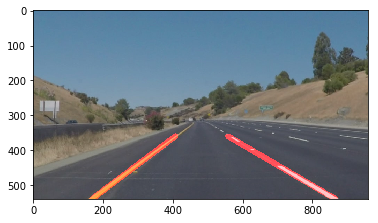

In [21]:
global_aver_negative_slope, global_aver_positive_slope = [],[]# reset frames values
processed_image = process_image(mpimg.imread('test_images/solidYellowCurve2.jpg'))

plt.imshow(processed_image)

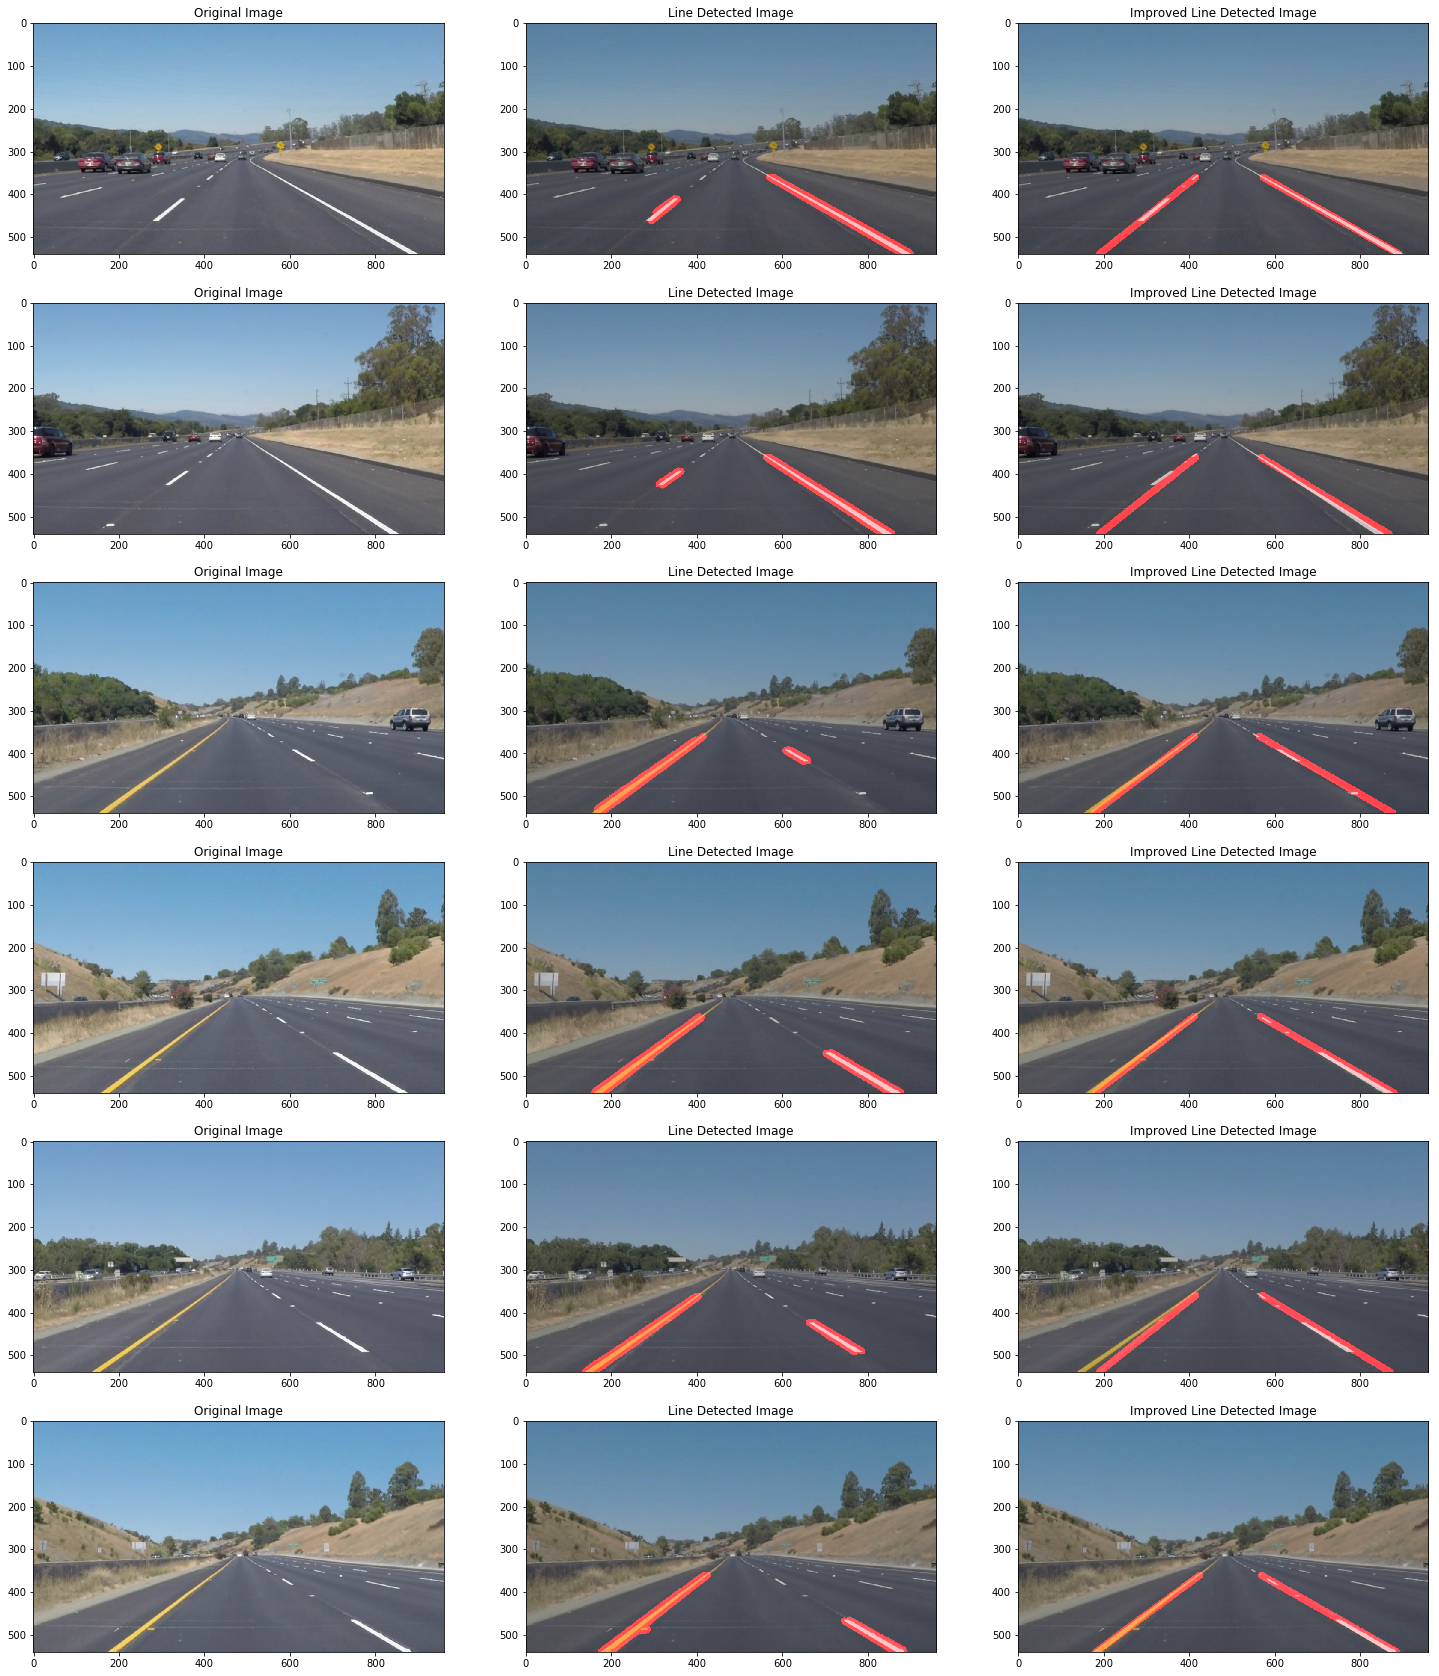

In [22]:
global_aver_negative_slope, global_aver_positive_slope = [],[] # reset frames values
display ('test_images/')

Let's try the one with the solid white lane on the right first ...

In [23]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [24]:
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
global_aver_negative_slope, global_aver_positive_slope = [],[] # reset frames values
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████▊| 221/222 [00:08<00:00, 25.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 9.52 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [26]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
global_aver_negative_slope, global_aver_positive_slope = [],[] # reset frames values
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████▉| 681/682 [00:26<00:00, 25.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 26.9 s


In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

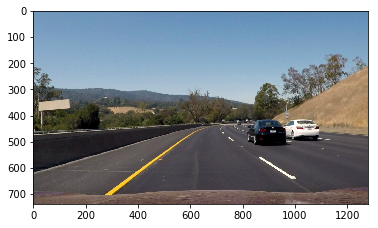

In [28]:
#reading in an image
image_cha = mpimg.imread('challenges/challenge_2.jpg')
plt.imshow(image_cha)

In [29]:
#Because challenge video size is different with those videos above, so re-calculate vertices.

# Region of interest mask
imshape = image_cha.shape
left_bottom   = [0,imshape[0]]
right_bottom  = [imshape[1],imshape[0]]
left_apex     = [imshape[1]//2-100, 2*imshape[0]//3] 
right_apex    = [imshape[1]//2+100, 2*imshape[0]//3]

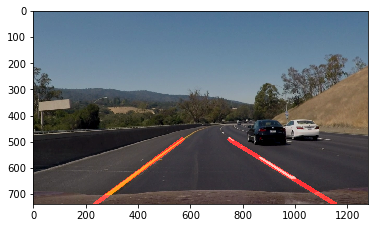

In [30]:
global_aver_negative_slope, global_aver_positive_slope = [],[]# reset frames values
processed_image = process_image(image_cha)

plt.imshow(processed_image)

In [31]:
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
global_aver_negative_slope, global_aver_positive_slope = [],[] # reset frames values
challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|████████████████████████████████████████| 251/251 [00:17<00:00, 14.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 18.5 s


In [32]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))